# CNN - Image Classification

In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')

print("GPU: ", tf.test.is_gpu_available())
print("TF version: ", tf.__version__)

GPU:  False
TF version:  2.0.0


In [2]:
# Data Preprocessing

# CIFAR-10 dataset has 10 classes and 60k examples, subset of 3 classes is used

def get_classes(x, y):
    indices0, _ = np.where(y==0.)
    indices1, _ = np.where(y==1.)
    indices2, _ = np.where(y==2.)
    
    indices = np.concatenate([indices0, indices1, indices2], axis=0)
    x=x[indices]
    y=y[indices]
    count=x.shape[0]
    # Shuffle the indices and have unique indices
    indices=np.random.choice(range(count), count, replace=False)
    x=x[indices]
    y=y[indices]
    
    # One hot encoding
    y= tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
# Testing the above function

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_classes(x_train, y_train)
x_test, y_test = get_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


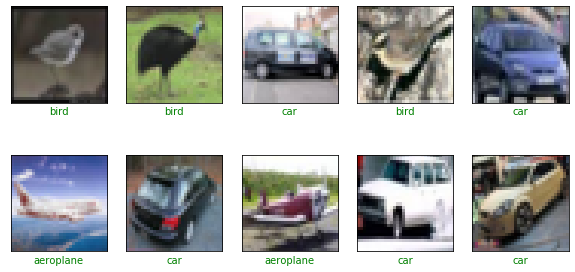

In [4]:
# Visualization

class_names = ['aeroplane', 'car', 'bird']

def show_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    x=x[indices]
    y=y[indices]
    p=p[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    
    plt.show()

show_examples(x_train, y_train, y_train)

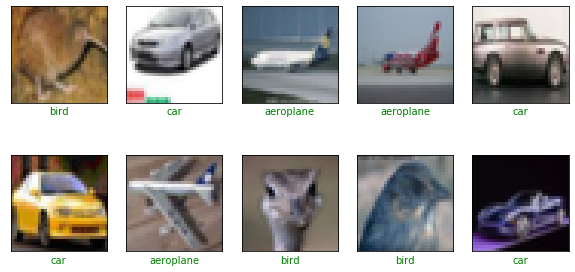

In [5]:
show_examples(x_test, y_test, y_test)

In [6]:
# Creating the model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, n_filters):
        model.add(Conv2D(n_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(n_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model

    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

In [11]:
# Training the model

history = model.fit(
          x_train/255., y_train, #Normalize to range [0, 1]
          validation_data=(x_test/255., y_test),
          epochs=10, batch_size=128,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=3),
              tf.keras.callbacks.ModelCheckpoint(
              'models/model_{val_accuracy:.3f}.h5',
              save_best_only=True, save_weights_only=False,
              monitor='val_accuracy')
          ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 73s 5ms/sample - loss: 0.5470 - accuracy: 0.7803 - val_loss: 2.7825 - val_accuracy: 0.3333
Epoch 2/10
15000/15000 [==============================] - 74s 5ms/sample - loss: 0.4742 - accuracy: 0.8137 - val_loss: 2.9102 - val_accuracy: 0.3433
Epoch 3/10
15000/15000 [==============================] - 74s 5ms/sample - loss: 0.4380 - accuracy: 0.8303 - val_loss: 2.6056 - val_accuracy: 0.4480
Epoch 4/10
15000/15000 [==============================] - 74s 5ms/sample - loss: 0.4007 - accuracy: 0.8427 - val_loss: 0.6918 - val_accuracy: 0.7363
Epoch 5/10
15000/15000 [==============================] - 73s 5ms/sample - loss: 0.3603 - accuracy: 0.8578 - val_loss: 0.6028 - val_accuracy: 0.7983
Epoch 6/10
15000/15000 [==============================] - 72s 5ms/sample - loss: 0.3345 - accuracy: 0.8693 - val_loss: 0.6031 - val_accuracy: 0.7790
Epoch 7/10
15000/15000 [==============================] -

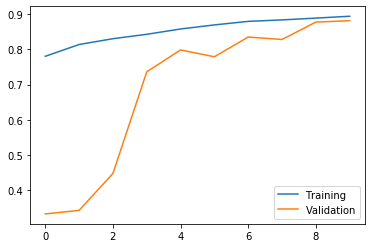

In [12]:
# Predictions
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(len(acc)), acc, label='Training')
plt.plot(range(len(acc)), val_acc, label='Validation')
plt.legend()
plt.show()

In [13]:
#model.save('models/model_0.877.h5')
model = tf.keras.models.load_model('models/model_0.881.h5')

In [14]:
preds = model.predict(x_test/255.)

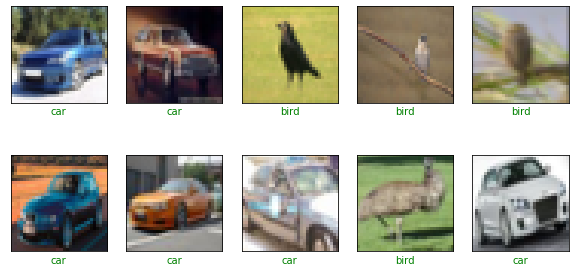

In [25]:
# Correct predictions (accuracy is almost 88%)
show_examples(x_test, y_test, preds)

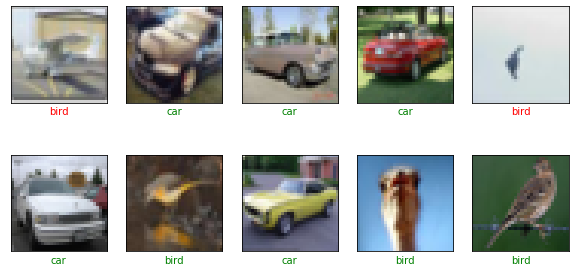

In [32]:
# Few wrong predictions
show_examples(x_test, y_test, preds)